In [1]:
# Standard library imports,
import time
import random
import string
import datetime

# Third-party imports,
import numpy as np
import matplotlib.pyplot as plt
from dataset import MNIST

# Torch imports,
import torch
from torchsummary import summary
import torch.nn.functional as Encoder
from torchvision import datasets
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader

## LeNet-5 Model & Training Method 

In [2]:
class ConfigDataset(Dataset):
    def __init__(self, path):
        """X is the training input while Y is the target output."""

        # Loading PyTorch dataset,
        dataset = torch.load(path)
        self.X = dataset.X
        self.Y = dataset.Y
        del dataset

        # One-hot encoding the target output,
        print("INFO: One-hot encoding target labels.")
        self.Y = Encoder.one_hot(self.Y, num_classes = 10).to(torch.float32)

    def __len__(self):
        """Returns the number of objects in the dataset."""
        return self.X.shape[0]
    
    def __getitem__(self, index):
        "Returns a tuple of training input and target output."
        return self.X[index], self.Y[index]

class NeuralNetwork(torch.nn.Module):
    """The neural network architecture."""

    def __init__(self):
        """Creating the layer stucture and activation functions of the neutral network."""
        super().__init__()

        # Layers,
        self.ConvolutionalLayer_INPUT = torch.nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = (1,1), padding = (2,2))
        self.PoolingLayer_HIDDEN_1 = torch.nn.AvgPool2d(kernel_size = (2,2), stride = (2,2))
        self.ConvolutionalLayer_HIDDEN_2 = torch.nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = (1,1))
        self.PoolingLayer_HIDDEN_3 = torch.nn.AvgPool2d(kernel_size = (2,2), stride = (2,2))
        self.DenseLayer_HIDDEN_4 = torch.nn.Linear(in_features = 16*5*5, out_features = 120)
        self.DenseLayer_HIDDEN_5 = torch.nn.Linear(in_features = 120, out_features = 84)
        self.DenseLayer_OUTPUT = torch.nn.Linear(in_features = 84, out_features = 10)

        # Activation functions,
        self.Sigmoid = torch.nn.Sigmoid()
        self.SoftMax = torch.nn.Softmax()

    def forward(self, X):
        """Defining the forward propagation."""

        X = self.ConvolutionalLayer_INPUT(X)
        X = self.Sigmoid(self.PoolingLayer_HIDDEN_1(X))
        X = self.ConvolutionalLayer_HIDDEN_2(X)
        X = self.Sigmoid(self.PoolingLayer_HIDDEN_3(X))

        X = X.view(-1, 16*5*5)
        X = self.DenseLayer_HIDDEN_4(X)
        X = self.DenseLayer_HIDDEN_5(X)
        X = self.SoftMax(self.DenseLayer_OUTPUT(X))

        return X

def TrainModel(training_data, neural_network, model_name, n_epochs = 10, learning_rate = 0.01):

    print(model_name)
    summary(neural_network, (1, 28, 28))
    print(" ")

    # Utilisation of CUDA if possible,
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f'CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}')
    else:
        device = torch.device("cpu")
        print('CUDA is not available. Using CPU.')

    neural_network.to(device)

    # Stochastic Gradient Descent (SGD) as optimiser,
    optimiser = SGD(neural_network.parameters(), lr = learning_rate)

    # Cross-Entropy loss function,
    loss_function = torch.nn.CrossEntropyLoss()

    losses = []
    epochs = np.arange(start = 1, stop = n_epochs, step = 1)

    for epoch in range(1, n_epochs + 1):
        epoch_loss = []
        stopwatch_start = time.time()
        for i, (X, Y) in enumerate(training_data):

            # Move data to selected device,
            X, Y = X.to(device), Y.to(device)

            # Back propagation,
            optimiser.zero_grad() 
            loss_value = loss_function(neural_network(X), Y) 
            epoch_loss.append(loss_value.item())
            loss_value.backward(loss_value) 
            optimiser.step()

        stopwatch_stop = time.time()
        epoch_time = round(stopwatch_stop - stopwatch_start, 2)
        epoch_avgloss = np.mean(epoch_loss)
        losses.append(epoch_avgloss)
        ETA = str(datetime.timedelta(seconds = (n_epochs - epoch)*epoch_time)).split(".")[0]
        update_string = f'[Completed Epoch: {epoch}/{n_epochs} - Time Taken: {epoch_time} secs - Loss: {epoch_avgloss:.5f} - ETA: {ETA} ]'
        print(update_string)

    torch.save(neural_network.state_dict(), f'{model_name}.pth')
    return np.array(epochs), np.array(losses)

def AssessModel(test_data, neural_network):

    X_test = test_data[:][0]
    Y_test = test_data[:][1]
    Yhat_test = neural_network(X_test)

    correct_counter = 0
    incorrect_counter = 0
    for Y, Yhat in zip(Y_test, Yhat_test):
        if Yhat.argmax() == Y.argmax():
            correct_counter += 1
        else:
            incorrect_counter += 1

    accuracy = correct_counter/(correct_counter + incorrect_counter)

    return accuracy

## Training Algorithm

INFO: One-hot encoding target labels.
Input Batch Shape: torch.Size([5, 1, 28, 28])
Target Batch Shape: torch.Size([5, 10])
Example Label: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


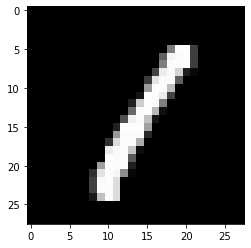


LeNet-JFW4E
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─AvgPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Sigmoid: 1-3                           [-1, 6, 14, 14]           --
├─Conv2d: 1-4                            [-1, 16, 10, 10]          2,416
├─AvgPool2d: 1-5                         [-1, 16, 5, 5]            --
├─Sigmoid: 1-6                           [-1, 16, 5, 5]            --
├─Linear: 1-7                            [-1, 120]                 48,120
├─Linear: 1-8                            [-1, 84]                  10,164
├─Linear: 1-9                            [-1, 10]                  850
├─Softmax: 1-10                          [-1, 10]                  --
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size

C:\Users\Prithvi\AppData\Local\Temp\ipykernel_6604\2309659645.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.SoftMax(self.DenseLayer_OUTPUT(X))


[Completed Epoch: 1/25 - Time Taken: 24.8 secs - Loss: 2.05257 - ETA: 0:09:55 ]
[Completed Epoch: 2/25 - Time Taken: 26.02 secs - Loss: 1.61114 - ETA: 0:09:58 ]
[Completed Epoch: 3/25 - Time Taken: 24.5 secs - Loss: 1.56697 - ETA: 0:08:59 ]
[Completed Epoch: 4/25 - Time Taken: 25.58 secs - Loss: 1.54645 - ETA: 0:08:57 ]
[Completed Epoch: 5/25 - Time Taken: 24.32 secs - Loss: 1.53053 - ETA: 0:08:06 ]
[Completed Epoch: 6/25 - Time Taken: 25.87 secs - Loss: 1.52373 - ETA: 0:08:11 ]
[Completed Epoch: 7/25 - Time Taken: 26.57 secs - Loss: 1.51946 - ETA: 0:07:58 ]
[Completed Epoch: 8/25 - Time Taken: 26.49 secs - Loss: 1.51184 - ETA: 0:07:30 ]
[Completed Epoch: 9/25 - Time Taken: 26.62 secs - Loss: 1.50788 - ETA: 0:07:05 ]
[Completed Epoch: 10/25 - Time Taken: 26.43 secs - Loss: 1.50459 - ETA: 0:06:36 ]
[Completed Epoch: 11/25 - Time Taken: 26.31 secs - Loss: 1.50039 - ETA: 0:06:08 ]
[Completed Epoch: 12/25 - Time Taken: 25.71 secs - Loss: 1.50009 - ETA: 0:05:34 ]
[Completed Epoch: 13/25 - T

In [3]:
# Hyperparameters,
EPOCHS = 25
BATCH_SIZE = 5
LEARNING_RATE = 0.01

if __name__ == "__main__":

    ID = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(5))
    model_name = "LeNet-" + ID

    # Creating and training neural network,
    training_dataset = ConfigDataset("training.pt")
    training_dataset_loaded = DataLoader(training_dataset, BATCH_SIZE)
    training_dataset_loaded.__dir__()

    # Displaying image,
    train_features, train_labels = next(iter(training_dataset_loaded))
    print(f"Input Batch Shape: {train_features.size()}")
    print(f"Target Batch Shape: {train_labels.size()}")
    
    random_index = random.randint(0, BATCH_SIZE - 1)
    label = train_labels[random_index]
    print(f"Example Label: {label}")

    img = train_features[random_index].squeeze()
    label = train_labels[random_index]
    plt.imshow(img, cmap = "gray")
    plt.show()
    print("")

    # Creating and training neural network,
    neural_network = NeuralNetwork()
    epoch_array, loss_array = TrainModel(training_dataset_loaded, neural_network, model_name, EPOCHS, LEARNING_RATE)

    # Testing neural network,
    test_dataset = ConfigDataset("test.pt")
    print("Accuracy: " + str(AssessModel(test_dataset, neural_network)))

## Model Loader

In [4]:
MODEL_FILE = "LeNet-JFW4E.pth"

# Loading model,
model = NeuralNetwork()
model.load_state_dict(torch.load(MODEL_FILE))
model.eval()

NeuralNetwork(
  (ConvolutionalLayer_INPUT): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (PoolingLayer_HIDDEN_1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (ConvolutionalLayer_HIDDEN_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (PoolingLayer_HIDDEN_3): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (DenseLayer_HIDDEN_4): Linear(in_features=400, out_features=120, bias=True)
  (DenseLayer_HIDDEN_5): Linear(in_features=120, out_features=84, bias=True)
  (DenseLayer_OUTPUT): Linear(in_features=84, out_features=10, bias=True)
  (Sigmoid): Sigmoid()
  (SoftMax): Softmax(dim=None)
)

## Visualisation

INFO: One-hot encoding target labels.


C:\Users\Prithvi\AppData\Local\Temp\ipykernel_6604\2309659645.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.SoftMax(self.DenseLayer_OUTPUT(X))


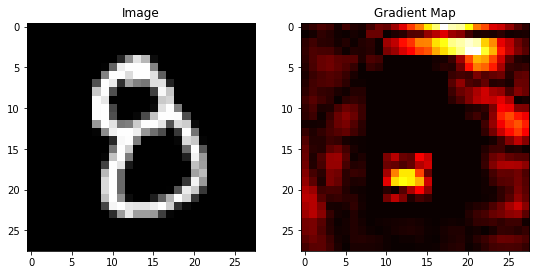

[Prediction: 8, Actual: 8]


In [5]:
test_dataset = ConfigDataset("test.pt")
idx = 1562

# Forward pass,
X_sample = test_dataset[:][0][idx]
X_sample = X_sample.unsqueeze(0)
X_sample.requires_grad = True

Y_sample = test_dataset[:][1][idx]
Y_pred = model(X_sample)

# Computing gradients with respect to the loss function via back propagation,
loss = Y_pred.max()
loss.backward()

# Calculate feature importance as the absolute mean of gradients found,
feature_importance = torch.abs(X_sample.grad).numpy().squeeze(0)
feature_image = feature_importance.reshape((28, 28, 1))
image = X_sample.detach().numpy().reshape((28, 28, 1))

# Plotting, 
figure, axis = plt.subplots(1, 2, figsize = (9, 9))
axis[0].imshow(image, cmap = "gray")
axis[0].set_title("Image")
axis[1].imshow(feature_image, cmap = "hot")
axis[1].set_title("Gradient Map")
plt.show()
print(f"[Prediction: {Y_pred.detach().numpy().argmax()}, Actual: {Y_sample.numpy().argmax()}]")